# **Assignment 3**

## **Sports Analytics**
Multi-Object Tracking (MOT) is a core visual ability that humans poses to perform kinetic tasks and coordinate other tasks. The AI community has recognized the importance of MOT via a series of [competitions](https://motchallenge.net/).

The assignment will give you the opportunity to apply probabilistic reasoning to sports analytics - a sizable market for AI. In this assignment the object classes are person and ball and you will demonstrate the ability to reason over time using [Kalman Filters](https://en.wikipedia.org/wiki/Kalman_filter).

### **Task 1: YOLO v11**

The *goal* of this assignment is to implement and analyze the YOLOv11 (You Only Look Once) object detection algorithm. Instead of building the model from scratch, you will use a state-of-the-art pre-trained model from the ultralytics library to perform inference on a video.

Your primary task is to create a Jupyter/Colab notebook that not only runs the detection but also explains and visualizes the core stages of the YOLOv11 pipeline. You will deconstruct the single-shot detection process by inspecting feature maps and the effect of post-processing techniques like Non-Max Suppression (NMS).

#### **Dataset**
You will be provided with a short video file (use the same video as test video). For your analysis and visualizations, you should select one representative frame from this video. The classes of interest, ‘person’ and ‘sports ball’, are both part of the MS COCO dataset, which the recommended pre-trained model has been trained on.

#### **Requirements**
Your submission must be a single notebook file (.ipynb) that includes all code, markdown explanations, and output visualizations.

Please note that both ball and person are included in the COCO dataset and you can use a pretrained on COCO backbone .

[Reference video](https://youtu.be/A1V8yYlGEkI)

In [ ]:
!pip install ultralytics opencv-python matplotlib yt-dlp --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.6 MB/s eta 0:00:00


In [ ]:
from yt_dlp import YoutubeDL

video_url = "https://www.youtube.com/watch?v=l3NJNFmg09k"

ydl_opts = {
    'format': 'bestvideo+bestaudio/best',
    'outtmpl': '%(title)s.%(ext)s'
}

with YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])

[youtube] Extracting URL: https://www.youtube.com/watch?v=l3NJNFmg09k
[youtube] l3NJNFmg09k: Downloading webpage
[youtube] l3NJNFmg09k: Downloading android sdkless player API JSON
[youtube] l3NJNFmg09k: Downloading tv client config
[youtube] l3NJNFmg09k: Downloading player 5cf6312f-main
[youtube] l3NJNFmg09k: Downloading tv player API JSON
[youtube] l3NJNFmg09k: Downloading web safari player API JSON


         player = https://www.youtube.com/s/player/5cf6312f/player_ias.vflset/en_US/base.js
         n = peVbfbMp2CT2Olq ; player = https://www.youtube.com/s/player/5cf6312f/player_ias.vflset/en_US/base.js
         Please report this issue on  https://github.com/yt-dlp/yt-dlp/issues?q= , filling out the appropriate issue template. Confirm you are on the latest version using  yt-dlp -U


[youtube] l3NJNFmg09k: Downloading m3u8 information
[info] l3NJNFmg09k: Downloading 1 format(s): 136+251
[download] Sleeping 2.00 seconds as required by the site...
[download] Destination: Football match.f136.mp4
[download] 100% of   11.07MiB in 00:00:00 at 14.42MiB/s  
[download] Destination: Football match.f251.webm
[download] 100% of  497.43KiB in 00:00:00 at 7.42MiB/s   
[Merger] Merging formats into "Football match.mkv"
Deleting original file Football match.f136.mp4 (pass -k to keep)
Deleting original file Football match.f251.webm (pass -k to keep)


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO("yolo11n.pt")

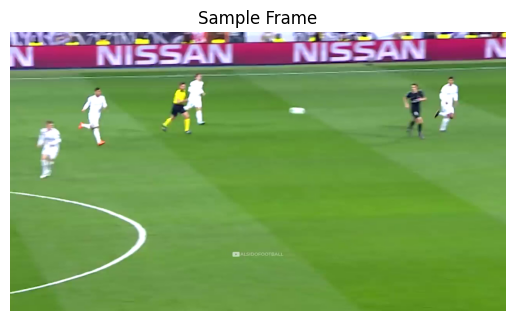

In [ ]:
video_path = "/content/Football match.mkv"
cap = cv2.VideoCapture(video_path)

ret, frame = cap.read()
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("Sample Frame")
plt.axis("off")
plt.show()

cap.release()



0: 384x640 9 persons, 1 sports ball, 2 chairs, 367.2ms
Speed: 18.4ms preprocess, 367.2ms inference, 41.3ms postprocess per image at shape (1, 3, 384, 640)


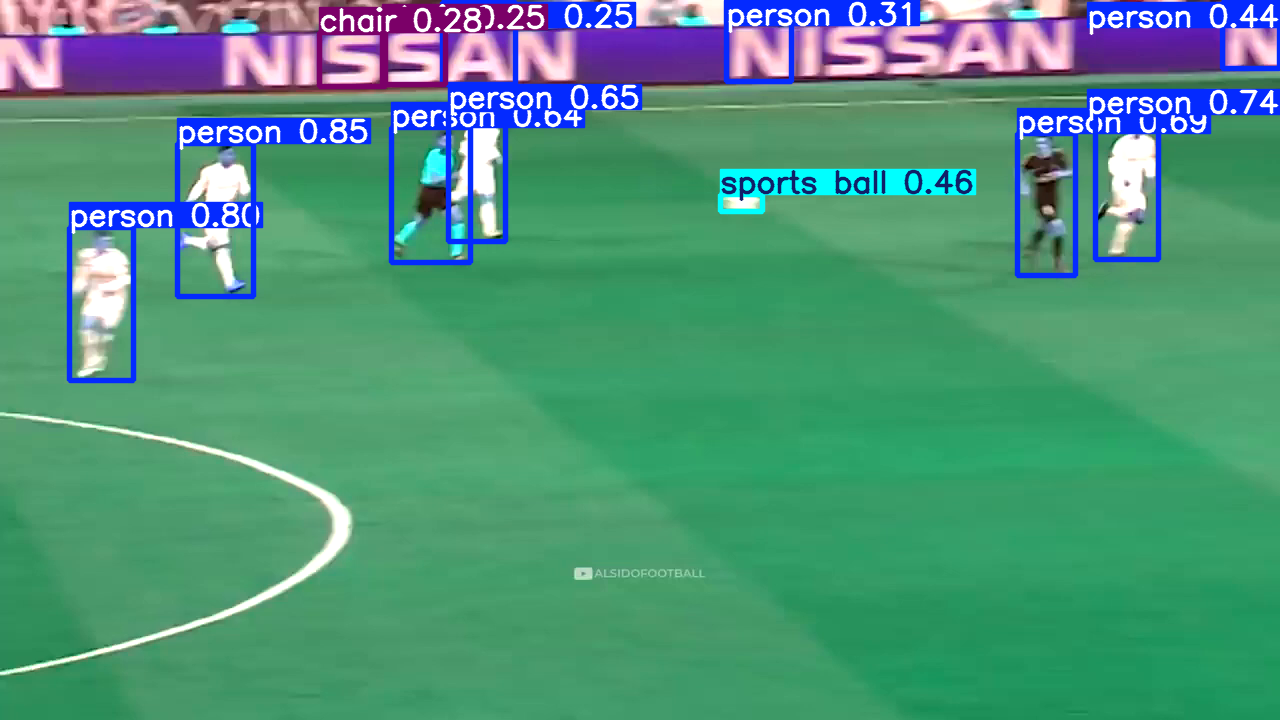

In [ ]:
results = model(img)
results[0].show()

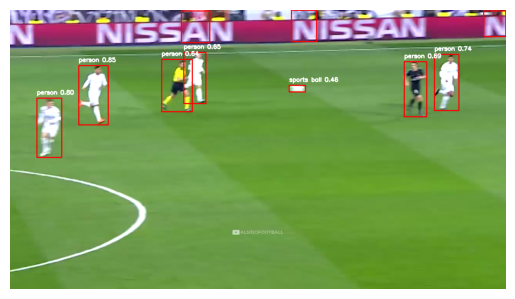

In [ ]:
boxes = results[0].boxes
names = model.names

for box in boxes:
    cls = int(box.cls)
    label = names[cls]
    if label in ["person", "sports ball"]:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(img, f"{label} {conf:.2f}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

plt.imshow(img)
plt.axis("off")
plt.show()



0: 384x640 6 persons, 2 chairs, 152.3ms
Speed: 2.8ms preprocess, 152.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


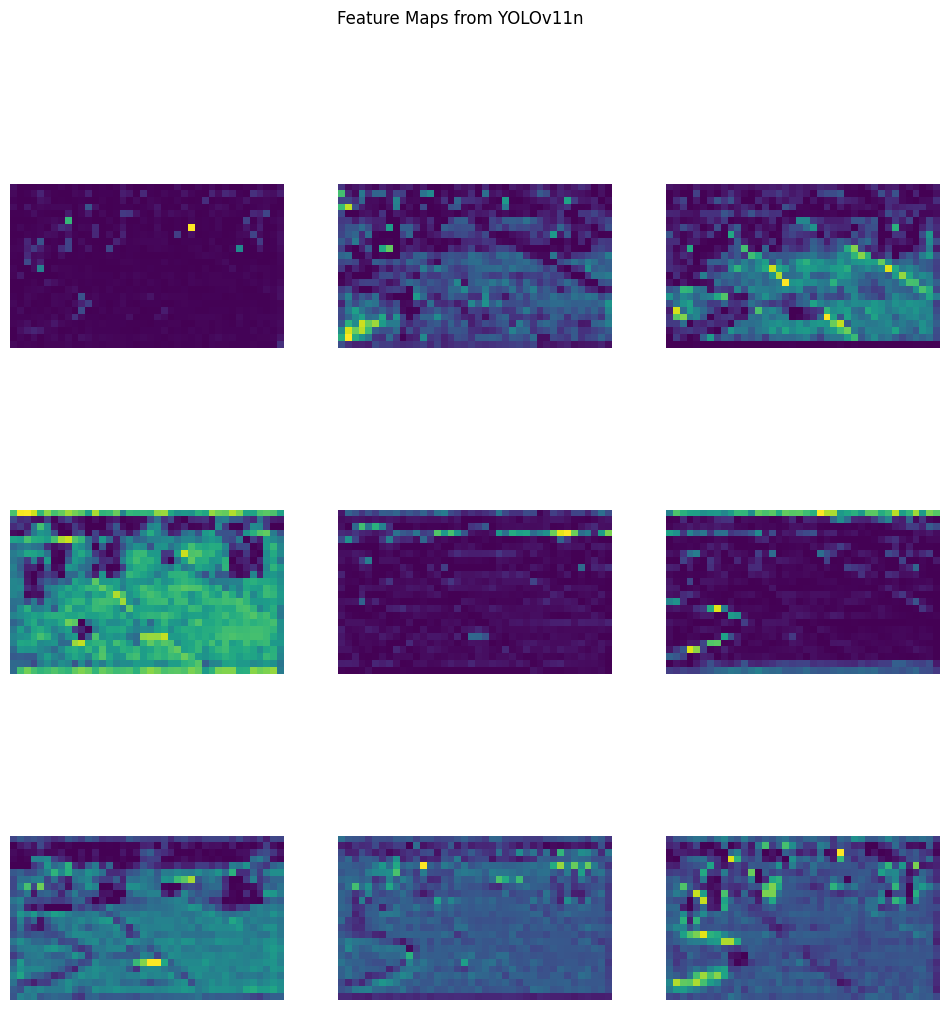

In [ ]:
layer = model.model.model[5]

activation = {}
def hook_fn(module, input, output):
    activation['feature_map'] = output.cpu().detach()

hook = layer.register_forward_hook(hook_fn)

_ = model(img)

# Visualize the feature map
feature_map = activation['feature_map'][0]
n_features = feature_map.shape[0]

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(feature_map[i].numpy())
    plt.axis('off')
plt.suptitle("Feature Maps from YOLOv11n")
plt.show()

hook.remove()


#### Writeup 
The visualizations above show feature maps extracted from YOLOv11n. 
1. Early Layers (Top Row) - Capture low-level visual patterns such as edges, colors, and simple textures. - Fine details and high spatial resolution dominate. - Useful for recognizing lines on the field, jersey edges, or motion blur outlines. 

2. Middle Layers (Middle Row) - Combine earlier features into mid-level structures like partial shapes or contours. - Activations become smoother, focusing on meaningful regions such as player outlines or ball-like clusters. 

3. Deep Layers (Bottom Row) - Represent complete objects or object parts. - We can see deeper activations of the lines, players and balls, this is a much more detailed layer